<center><font size="15">Labyrinth Solving with </font></center>
  

&nbsp;


    
<center><font size="15">Deep Reinforcement Learning</font></center>

### WriteUp

------------------


<font size="4">
<u>Goal</u>
    
    
My project aims to create a Deep RL bot that can navigate through a maze. The Agent should be able to drop into any state in the maze, and close to optimally find the exit. 

------------------------
<u>Methodolgy</u>

To do this, the Agent would first have to determine the optimal Q-Values for each state inside the maze. To calculate the Q-Values, it would have to explore the maze environment several times, and learn the optimal direction to take depending on which state it is on. It would have to find the correlation between the (X,Y) coordinates and the correct direction to go.

We start by deciding what neural network is best fitted for this task. I decided to use a simple feed forwards neural network, with 2 inputs : (X,Y) of a state. It would have 2 dense layers, with 64 neurons each, to do the processing and find patterns. Finally, it would have 4 outputs, being how confident it is in going in each direction (left, right, up down).

At first, the neural network's weight are randomly intialised. Therefore, it will make random predictions of which direction to go in.

These are the steps followed by the Agent to explore and learn from the environment:

---------------------------------
1. Appears on starting state



2. Uses Neural Network to make a prediction on which direction to move in


3. Moves to decided position, and collects reward / penalty


4. Stores the action it took, and the reward obtained for the transition


5. Keeps repeating steps (2, 3, 4) until it either reaches the exit, or reaches a certain penalty level


6. Trains itself on 32 samples of the data it obtained, the inputs being the state it was on, and the output being the normalised reward obtained for each of the 4 states



7. Tests how good it is at reaching the exit by trying to finish the maze for 50 different starting points in the maze

--------------------



These 6 steps for an "episode". After each episode, it becomes a little bit better at predicting which state would be the most optimal.

When it is able to exit the maze for all possible starting points, the training / exploration process is done.

--------------------------

<u>Environment</u>

Throughout the learning and testing process, our Agent is interacting with the maze environment. This environment has a class with several different functions to execute the movements of our Agent and return the reward / penalty.

These are the rewards / penalties that can be obtained:


1. Agent moves to a new state that is not the exit : -0.25



2. Agent retraces its steps and lands on a state its has already visited : -0.75



3. Agent reaches exit state : 10 

---------------

<u>Results / Conclusions</u>


After running my deep reinforcement learning Agent for 600 episodes it was winning every single episode it had gone through.
Here is an example of the moves the Agent executed to escape the Maze:

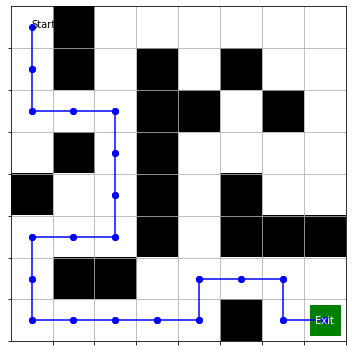


This same algorythm could be applied to a much larger maze, and Deep RL Networks look like a very precise way of finding their way out of mazes. The only downside is that it takes a slighlty longer time to train


### STEP 1 : Importing Required Libraries
----------------
These libraries include data libraries such as Numpy and Matplotlib

As well as Tensorflow and Keras, to create our Agent

In [1]:
import logging
from enum import Enum, IntEnum

import matplotlib.pyplot as plt
import numpy as np

import logging
import random
from datetime import datetime

import numpy as np
np.random.seed(1)

import tensorflow

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

### STEP 2 : Creating the Maze Environment

------------------

The first thing to do is code the Maze Environment that the Agent should go through.

In [78]:
#######################################################################################################################
class Cell(IntEnum):
    EMPTY = 0  # Empty cells that can be moved to
    OCCUPIED = 1 # Cell containing a wall
    CURRENT = 2  # Cell the agent is on right now

#-----------------------------------------------------------------

#Defining directions that the Agent can move in
class Action(IntEnum):
    MOVE_LEFT = 0   #Left
    MOVE_RIGHT = 1  #Right
    MOVE_UP = 2     #Up
    MOVE_DOWN = 3   #Down
#-----------------------------------------------------------------
#This is to help us visualise the Maze
class Render(Enum):
    NOTHING = 0
    TRAINING = 1
    MOVES = 2
#-----------------------------------------------------------------
# The status of the Agent during the game
class Status(Enum):
    WIN = 0
    LOSE = 1
    PLAYING = 2

#######################################################################################################################
class Maze:
    actions = [Action.MOVE_LEFT, Action.MOVE_RIGHT, Action.MOVE_UP, Action.MOVE_DOWN]  # all possible actions

    reward_exit = 10.0  # reward for completing the Maze
    penalty_move = -0.05  # Penalty for each move it takes, to ensure Agent takes fastest possible route.
    penalty_visited = -0.25  # penalty for retracing its steps and going to a cell it has already been to
    penalty_impossible_move = -0.75  # Penalty for trying to take an illegal move
#######################################################################################################################
    def __init__(self, maze, start_cell=(0, 0), exit_cell=None):
        
        # The Maze should be a 2D array containing cells (0 for empty cell, 1 for wall)
        #Start cell is the starting position of the cell
        # Exit_Cell is the end of the maze, where the Agent wants to reach
        
        self.maze = maze

        self.__minimum_reward = -0.5 * self.maze.size  # stop game if accumulated reward is below this threshold

        nrows, ncols = self.maze.shape
        self.cells = [(col, row) for col in range(ncols) for row in range(nrows)]
        self.empty = [(col, row) for col in range(ncols) for row in range(nrows) if self.maze[row, col] == Cell.EMPTY]
        self.__exit_cell = (ncols - 1, nrows - 1) if exit_cell is None else exit_cell
        self.empty.remove(self.__exit_cell)

        # Check for incompatibilities in Maze
        if self.__exit_cell not in self.cells:
            raise Exception("Error: exit cell at {} is outside maze".format(self.__exit_cell))
        if self.maze[self.__exit_cell[::-1]] == Cell.OCCUPIED:
            raise Exception("Error: exit cell at {} is inside a wall".format(self.__exit_cell))

        # Variables for rendering
        self.__render = Render.NOTHING  # what to render
        self.__ax1 = None  # axes for rendering the moves
        self.__ax2 = None  # axes for rendering the best action per cell

        self.reset(start_cell)
#######################################################################################################################
    # Resetting the Agent and Maze
    def reset(self, start_cell=(0, 0)):
        
        if start_cell not in self.cells:
            raise Exception("Error: exit cell at {} is outside maze".format(start_cell))
        if self.maze[start_cell[::-1]] == Cell.OCCUPIED:
            raise Exception("Error: start cell at {} is a wall".format(start_cell))
        if start_cell == self.__exit_cell:
            raise Exception("Error: start and exit cell cannot be the same {}".format(start_cell))

        self.__previous_cell = self.__current_cell = start_cell # The agent starts on the start cell
        self.__total_reward = 0.0  # accumulated reward
        self.__visited = set()  # set of places Agent has visited

        if self.__render in (Render.TRAINING, Render.MOVES):
            # render the maze
            nrows, ncols = self.maze.shape
            self.__ax1.clear()
            self.__ax1.set_xticks(np.arange(0.5, nrows, step=1))
            self.__ax1.set_xticklabels([])
            self.__ax1.set_yticks(np.arange(0.5, ncols, step=1))
            self.__ax1.set_yticklabels([])
            self.__ax1.grid(True)
            self.__ax1.plot(*self.__current_cell, "rs", markersize=30)  # start is a big red square
            self.__ax1.text(*self.__current_cell, "Start", ha="center", va="center", color="white")
            self.__ax1.plot(*self.__exit_cell, "gs", markersize=30)  # exit is a big green square
            self.__ax1.text(*self.__exit_cell, "Exit", ha="center", va="center", color="white")
            self.__ax1.imshow(self.maze, cmap="binary")
            self.__ax1.get_figure().canvas.draw()
            self.__ax1.get_figure().canvas.flush_events()

        return self.__observe()
    
#######################################################################################################################    
    
    # Draws the path takes by the Agent so far
    def __draw(self):
        self.__ax1.plot(*zip(*[self.__previous_cell, self.__current_cell]), "bo-")  # previous cells are blue dots
        self.__ax1.plot(*self.__current_cell, "ro")  # current cell is a red dot
        self.__ax1.get_figure().canvas.draw()
        self.__ax1.get_figure().canvas.flush_events()
#######################################################################################################################
    def render(self, content=Render.NOTHING):
        self.__render = content

        if self.__render == Render.NOTHING:
            if self.__ax1:
                self.__ax1.get_figure().close()
                self.__ax1 = None
            if self.__ax2:
                self.__ax2.get_figure().close()
                self.__ax2 = None
        if self.__render == Render.TRAINING:
            if self.__ax2 is None:
                fig, self.__ax2 = plt.subplots(1, 1, tight_layout=True)
                fig.canvas.set_window_title("Best move")
                self.__ax2.set_axis_off()
                self.render_q(None)
        if self.__render in (Render.MOVES, Render.TRAINING):
            if self.__ax1 is None:
                fig, self.__ax1 = plt.subplots(1, 1, tight_layout=True)
                fig.canvas.set_window_title("Maze")

        plt.show(block=False)
#######################################################################################################################
    # Moves the Agent to a requested place.
    # Returns the reward, status, and new state for Agent
    def step(self, action):

        reward = self.__execute(action) # Gets reward for state
        self.__total_reward += reward # Adds reward to accumulated reward
        status = self.__status()
        state = self.__observe()
        logging.debug("action: {:10s} | reward: {: .2f} | status: {}".format(Action(action).name, reward, status))
        return state, reward, status
#######################################################################################################################
    # Executes the requested move for Agent
    def __execute(self, action):
        
        #Gets legall moves for agent
        possible_actions = self.__possible_actions(self.__current_cell)

        if not possible_actions:
            reward = self.__minimum_reward - 1  # cannot move anywhere, force end of game
        elif action in possible_actions:
            col, row = self.__current_cell
            if action == Action.MOVE_LEFT:
                col -= 1
            elif action == Action.MOVE_UP:
                row -= 1
            if action == Action.MOVE_RIGHT:
                col += 1
            elif action == Action.MOVE_DOWN:
                row += 1

            self.__previous_cell = self.__current_cell
            self.__current_cell = (col, row)

            if self.__render != Render.NOTHING:
                self.__draw()

            if self.__current_cell == self.__exit_cell:
                reward = Maze.reward_exit  # maximum reward when reaching the exit cell
            elif self.__current_cell in self.__visited:
                reward = Maze.penalty_visited  # penalty when returning to a cell which was visited earlier
            else:
                reward = Maze.penalty_move  # penalty for a move which did not result in finding the exit cell

            self.__visited.add(self.__current_cell)
        else:
            reward = Maze.penalty_impossible_move  # penalty for trying to enter an occupied cell or move out of the maze

        return reward
#######################################################################################################################
    #Creates list of possible actions that can be taken by the Agent
    def __possible_actions(self, cell=None):
        if cell is None:
            col, row = self.__current_cell
        else:
            col, row = cell

        possible_actions = Maze.actions.copy()  #Start by taking all possible actions

        #Looping through all actions and discarding illegal ones
        nrows, ncols = self.maze.shape
        if row == 0 or (row > 0 and self.maze[row - 1, col] == Cell.OCCUPIED):
            possible_actions.remove(Action.MOVE_UP)
        if row == nrows - 1 or (row < nrows - 1 and self.maze[row + 1, col] == Cell.OCCUPIED):
            possible_actions.remove(Action.MOVE_DOWN)

        if col == 0 or (col > 0 and self.maze[row, col - 1] == Cell.OCCUPIED):
            possible_actions.remove(Action.MOVE_LEFT)
        if col == ncols - 1 or (col < ncols - 1 and self.maze[row, col + 1] == Cell.OCCUPIED):
            possible_actions.remove(Action.MOVE_RIGHT)

        return possible_actions
#######################################################################################################################
    #Returns if the Agent has finished, or is still playing the Maze
    def __status(self):
        if self.__current_cell == self.__exit_cell:
            return Status.WIN

        if self.__total_reward < self.__minimum_reward:  # force end of game after to much loss
            return Status.LOSE

        return Status.PLAYING
#######################################################################################################################
    #Return the Agents location in the Maze for visualization
    def __observe(self):
        return np.array([[*self.__current_cell]])
#######################################################################################################################
    #Play 1 simulated game in the maze environment, with visualizations
    def play(self, model, start_cell=(0, 0)):

        self.reset(start_cell) #Resets the Maze

        state = self.__observe() # Finds Agents current location
        all_states = [state]
        while True:
            action = model.predict(state=state) # Model predicts an action
            state, reward, status = self.step(action) # Get new state, and reward for action
            # return if the Agent wins or looses at the end of the game
            all_states.append(state)
            if status in (Status.WIN, Status.LOSE):
                return status, all_states
#######################################################################################################################
    # This checks if the Model can beat the maze in all possible starting positions
    def check_win_all(self, model):
        
        previous = self.__render
        self.__render = Render.NOTHING  # Dont render visual game during checks

        win = 0
        lose = 0

        #Plays from all 
        for cell in self.empty:
            if self.play(model, cell) == Status.WIN:
                win += 1
            else:
                lose += 1

        self.__render = previous  # restore previous rendering setting

        logging.info("won: {} | lost: {} | win rate: {:.5f}".format(win, lose, win / (win + lose)))

        result = True if lose == 0 else False

        return result, win / (win + lose)
#######################################################################################################################
    # Visualy Render Actions By Model
    def render_q(self, model):
        def clip(n):
            return max(min(1, n), 0)

        if self.__render == Render.TRAINING:
            nrows, ncols = self.maze.shape

            self.__ax2.clear()
            self.__ax2.set_xticks(np.arange(0.5, nrows, step=1))
            self.__ax2.set_xticklabels([])
            self.__ax2.set_yticks(np.arange(0.5, ncols, step=1))
            self.__ax2.set_yticklabels([])
            self.__ax2.grid(True)
            self.__ax2.plot(*self.__exit_cell, "gs", markersize=30)  # exit is a big green square
            self.__ax2.text(*self.__exit_cell, "Exit", ha="center", va="center", color="white")

            for cell in self.empty:
                q = model.q(cell) if model is not None else [0, 0, 0, 0]
                a = np.nonzero(q == np.max(q))[0]

                for action in a:
                    dx = 0
                    dy = 0
                    if action == Action.MOVE_LEFT:
                        dx = -0.2
                    if action == Action.MOVE_RIGHT:
                        dx = +0.2
                    if action == Action.MOVE_UP:
                        dy = -0.2
                    if action == Action.MOVE_DOWN:
                        dy = 0.2

                    # color (red to green) represents the certainty
                    color = clip((q[action] - -1)/(1 - -1))

                    self.__ax2.arrow(*cell, dx, dy, color=(1 - color, color, 0), head_width=0.2, head_length=0.1)

            self.__ax2.imshow(self.maze, cmap="binary")
            self.__ax2.get_figure().canvas.draw()
            

### STEP 3 : Creating the Q-learning Model
------------------
We would like to create an Agent that can solve this maze, by estimating what transition to execute at what state, to reach the exit of the maze the most efficiently, and Maximize accumulated rewards

------------------------------

The first thing we need to do, is explore the Maze with a random Model. The ExperienceReplay class plays the maze randomly and gathers training samples

In [3]:
#######################################################################################################################
# First, we would like to record the reward for different transitions, of 1 state to another
class ExperienceReplay:

    def __init__(self, model, max_memory=1000, discount=0.95):
        
        # We start with a randomly initialized keras Neural Network model. In our sample set, we will record a maximum of 
        # 1000 transition samples
        
        self.model = model
        self.discount = discount
        self.memory = list()
        self.max_memory = max_memory
#######################################################################################################################
    # Add transition made by Agent to list of transition.
    def remember(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.max_memory:
            del self.memory[0]  # forget the oldest memories if needed
#######################################################################################################################
    # Predicting Q-Value for current state
    def predict(self, state):
        return self.model.predict(state)[0]  # prediction is a [1][num_actions] array with Q's
#######################################################################################################################
    # Randomly request a number of game states, and their corresponding targets
    def get_samples(self, sample_size=10):
        
        mem_size = len(self.memory)  # how many episodes are currently stored
        sample_size = min(mem_size, sample_size)  # cannot take more samples then available in memory
        state_size = self.memory[0][0].size
        num_actions = self.model.output_shape[-1]  # number of actions in output layer

        states = np.zeros((sample_size, state_size), dtype=int)
        targets = np.zeros((sample_size, num_actions), dtype=float)

        # update the Q's from the sample
        for i, idx in enumerate(np.random.choice(range(mem_size), sample_size, replace=False)):
            state, move, reward, next_state, status = self.memory[idx]

            states[i] = state
            targets[i] = self.predict(state)

            if status == "win":
                targets[i, move] = reward  # no discount needed if a terminal state was reached.
            else:
                targets[i, move] = reward + self.discount * np.max(self.predict(next_state))

        return states, targets


-------------------
Next we we will create the actual Neural Network.

This network will work by replaying a batch of training moves. Training ends after a number of games, or if it achives a 100% win rate

---------------------------

In [7]:
#######################################################################################################################
class QReplayNetworkModel:

    default_check_convergence_every = 5  # by default check for convergence every # episodes

    def __init__(self, game):
            
        #The Neural Network:
        # The network complexity increases with a larger maze size
        self.model = Sequential()
        self.model.add(Dense(game.maze.size, input_shape=(2,), activation="relu")) # Input is the current state (X, Y)
        self.model.add(Dense(game.maze.size, activation="relu"))
        self.model.add(Dense(len(game.actions))) # Output should be either left, right, up, or down (4 possibilites)

        # Compile Model with Adam optimizer
        self.model.compile(optimizer="adam", loss="mse")
#######################################################################################################################
    # Save NN Model
    def save(self, filename):
        with open(filename + ".json", "w") as outfile:
            outfile.write(self.model.to_json())
        self.model.save_weights(filename + ".h5", overwrite=True)
#######################################################################################################################
    # Load Model file
    def load(self, filename):
        with open(filename + ".json", "r") as infile:
            self.model = model_from_json(infile.read())
        self.model.load_weights(filename + ".h5")
#######################################################################################################################
    # Train Model based on collected samples
    #Returns training epochs completed, and time taken
    def train(self, stop_at_convergence=False, **kwargs):

        winning_games = []
        
        discount = kwargs.get("discount", 0.90)
        exploration_rate = kwargs.get("exploration_rate", 0.10)
        exploration_decay = kwargs.get("exploration_decay", 0.995)  # % reduction per step = 100 - exploration decay
        episodes = max(kwargs.get("episodes", 1000), 1)
        sample_size = kwargs.get("sample_size", 32)
        check_convergence_every = kwargs.get("check_convergence_every", self.default_check_convergence_every)

        experience = ExperienceReplay(self.model, discount=discount)

        # variables for reporting purposes
        cumulative_reward = 0
        cumulative_reward_history = []
        win_history = []

        start_list = list()  # starting cells not yet used for training
        start_time = datetime.now()
#-----------------------------------------------------------------
        # training starts here
        for episode in range(1, episodes + 1):
            if not start_list:
                start_list = game.empty.copy()
                
            moves = []
        
            start_cell = random.choice(start_list)
            
            
            start_list.remove(start_cell)

            state = game.reset(start_cell)
            moves.append(state)

            loss = 0.0
#-----------------------------------------------------------------
            while True:
                #Randomly takes an action, once in a while
                if np.random.random() < exploration_rate:
                    action = random.choice(game.actions)
                else:
                    action = self.predict(state)

                next_state, reward, status = game.step(action)
                moves.append(next_state)
                cumulative_reward += reward

                experience.remember([state, action, reward, next_state, status])

                if status in (Status.WIN, Status.LOSE):  # terminal state reached, stop episode
                    break

                inputs, targets = experience.get_samples(sample_size=sample_size)

                self.model.fit(inputs,
                               targets,
                               epochs=4,
                               batch_size=16,
                               verbose=0)
                loss += self.model.evaluate(inputs, targets, verbose=0)

                state = next_state

                game.render_q(self)

            cumulative_reward_history.append(cumulative_reward)
            
            if status.name == 'WIN':
                winning_games.append(moves)
            print("-------------------------------------------------------------------")
            print("episode: {:d}/{:d} | status: {:4s} | loss: {:.4f} | e: {:.5f}"
                         .format(episode, episodes, status.name, loss, exploration_rate))
            print("-------------------------------------------------------------------")
#-----------------------------------------------------------------
            if episode % check_convergence_every == 0:
                # check if the current model does win from all starting cells
                # only possible if there is a finite number of starting states
                print("EPOCH : ", episode)
                w_all, win_rate = game.check_win_all(self)
                win_history.append((episode, win_rate))
                print("Win Rate : ", win_rate)
                if w_all is True and stop_at_convergence is True:
                    logging.info("won from all start cells, stop learning")
                    break

            exploration_rate *= exploration_decay  # explore less as training progresses
#-----------------------------------------------------------------
        self.save('model1.h5')  # Save trained models weights and architecture

        logging.info("episodes: {:d} | time spent: {}".format(episode, datetime.now() - start_time))

        return cumulative_reward_history, win_history, episode, datetime.now() - start_time, winning_games
#######################################################################################################################
    # Get Q-Values for all action for a certain state
    def q(self, state):
        if type(state) == tuple:
            state = np.array(state, ndmin=2)

        return self.model.predict(state)[0]
#######################################################################################################################
    # Chooses action for state with highest Q-Value
    def predict(self, state):
        q = self.q(state)

        logging.debug("q[] = {}".format(q))

        actions = np.nonzero(q == np.max(q))[0]  # get index of the action(s) with the max value
        return random.choice(actions)

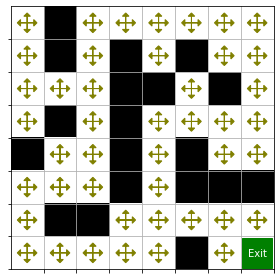

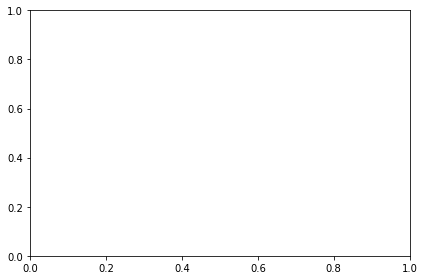

Training...
-------------------------------------------------------------------
episode: 1/600 | status: LOSE | loss: 0.7079 | e: 0.10000
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 2/600 | status: LOSE | loss: 1.0024 | e: 0.09950
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 3/600 | status: LOSE | loss: 0.9917 | e: 0.09900
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 4/600 | status: LOSE | loss: 0.3428 | e: 0.09851
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 5/600 | status: LOSE | loss: 0.3966 | e: 0.09801
-------------------------------------------------------------------
EPOCH :  5
Win Rat

-------------------------------------------------------------------
episode: 42/600 | status: LOSE | loss: 22.2794 | e: 0.08142
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 43/600 | status: WIN  | loss: 1.2264 | e: 0.08102
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 44/600 | status: WIN  | loss: 26.1007 | e: 0.08061
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 45/600 | status: WIN  | loss: 5.1923 | e: 0.08021
-------------------------------------------------------------------
EPOCH :  45
Win Rate :  0.0
-------------------------------------------------------------------
episode: 46/600 | status: WIN  | loss: 2.2904 | e: 0.07981
---------------------------------------------------------------

-------------------------------------------------------------------
episode: 83/600 | status: WIN  | loss: 0.0915 | e: 0.06630
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 84/600 | status: LOSE | loss: 7.4155 | e: 0.06597
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 85/600 | status: WIN  | loss: 8.3146 | e: 0.06564
-------------------------------------------------------------------
EPOCH :  85
Win Rate :  0.0
-------------------------------------------------------------------
episode: 86/600 | status: WIN  | loss: 0.5296 | e: 0.06531
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 87/600 | status: WIN  | loss: 4.0080 | e: 0.06498
-----------------------------------------------------------------

-------------------------------------------------------------------
episode: 124/600 | status: WIN  | loss: 0.9755 | e: 0.05398
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 125/600 | status: WIN  | loss: 0.4212 | e: 0.05371
-------------------------------------------------------------------
EPOCH :  125
Win Rate :  0.0
-------------------------------------------------------------------
episode: 126/600 | status: WIN  | loss: 1.0493 | e: 0.05344
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 127/600 | status: WIN  | loss: 0.4342 | e: 0.05318
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 128/600 | status: WIN  | loss: 0.1050 | e: 0.05291
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 165/600 | status: WIN  | loss: 0.2509 | e: 0.04395
-------------------------------------------------------------------
EPOCH :  165
Win Rate :  0.0
-------------------------------------------------------------------
episode: 166/600 | status: WIN  | loss: 0.2651 | e: 0.04373
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 167/600 | status: WIN  | loss: 0.8280 | e: 0.04351
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 168/600 | status: WIN  | loss: 0.2815 | e: 0.04330
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 169/600 | status: WIN  | loss: 0.8231 | e: 0.04308
-----------------------------------------------------------

Win Rate :  0.0
-------------------------------------------------------------------
episode: 206/600 | status: WIN  | loss: 1.5966 | e: 0.03579
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 207/600 | status: WIN  | loss: 0.2876 | e: 0.03561
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 208/600 | status: WIN  | loss: 1.1513 | e: 0.03543
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 209/600 | status: WIN  | loss: 0.1913 | e: 0.03525
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 210/600 | status: WIN  | loss: 0.4392 | e: 0.03508
-------------------------------------------------------------------
EPOC

-------------------------------------------------------------------
episode: 247/600 | status: WIN  | loss: 0.2967 | e: 0.02914
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 248/600 | status: WIN  | loss: 0.2020 | e: 0.02899
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 249/600 | status: WIN  | loss: 1.6930 | e: 0.02885
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 250/600 | status: WIN  | loss: 0.0507 | e: 0.02870
-------------------------------------------------------------------
EPOCH :  250
Win Rate :  0.0
-------------------------------------------------------------------
episode: 251/600 | status: WIN  | loss: 0.2094 | e: 0.02856
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 288/600 | status: WIN  | loss: 0.4264 | e: 0.02373
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 289/600 | status: WIN  | loss: 0.1269 | e: 0.02361
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 290/600 | status: WIN  | loss: 0.0055 | e: 0.02349
-------------------------------------------------------------------
EPOCH :  290
Win Rate :  0.0
-------------------------------------------------------------------
episode: 291/600 | status: WIN  | loss: 0.3210 | e: 0.02337
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 292/600 | status: WIN  | loss: 0.0369 | e: 0.02326
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 329/600 | status: WIN  | loss: 0.0014 | e: 0.01932
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 330/600 | status: WIN  | loss: 0.1423 | e: 0.01922
-------------------------------------------------------------------
EPOCH :  330
Win Rate :  0.0
-------------------------------------------------------------------
episode: 331/600 | status: WIN  | loss: 0.3639 | e: 0.01913
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 332/600 | status: WIN  | loss: 0.0529 | e: 0.01903
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 333/600 | status: WIN  | loss: 0.3575 | e: 0.01893
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 370/600 | status: WIN  | loss: 0.2241 | e: 0.01573
-------------------------------------------------------------------
EPOCH :  370
Win Rate :  0.0
-------------------------------------------------------------------
episode: 371/600 | status: WIN  | loss: 0.0915 | e: 0.01565
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 372/600 | status: WIN  | loss: 0.0530 | e: 0.01557
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 373/600 | status: WIN  | loss: 0.1435 | e: 0.01549
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 374/600 | status: WIN  | loss: 0.0499 | e: 0.01542
-----------------------------------------------------------

Win Rate :  0.0
-------------------------------------------------------------------
episode: 411/600 | status: WIN  | loss: 0.0994 | e: 0.01281
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 412/600 | status: WIN  | loss: 0.2931 | e: 0.01274
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 413/600 | status: WIN  | loss: 0.0711 | e: 0.01268
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 414/600 | status: WIN  | loss: 0.0992 | e: 0.01262
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 415/600 | status: WIN  | loss: 0.1024 | e: 0.01255
-------------------------------------------------------------------
EPOC

-------------------------------------------------------------------
episode: 452/600 | status: WIN  | loss: 0.1017 | e: 0.01043
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 453/600 | status: WIN  | loss: 0.0919 | e: 0.01038
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 454/600 | status: WIN  | loss: 0.0821 | e: 0.01032
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 455/600 | status: WIN  | loss: 0.0000 | e: 0.01027
-------------------------------------------------------------------
EPOCH :  455
Win Rate :  0.0
-------------------------------------------------------------------
episode: 456/600 | status: WIN  | loss: 0.0711 | e: 0.01022
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 493/600 | status: WIN  | loss: 0.0697 | e: 0.00849
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 494/600 | status: WIN  | loss: 0.0230 | e: 0.00845
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 495/600 | status: WIN  | loss: 0.0975 | e: 0.00841
-------------------------------------------------------------------
EPOCH :  495
Win Rate :  0.0
-------------------------------------------------------------------
episode: 496/600 | status: WIN  | loss: 0.0435 | e: 0.00836
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 497/600 | status: WIN  | loss: 0.0906 | e: 0.00832
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 534/600 | status: WIN  | loss: 0.0190 | e: 0.00691
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 535/600 | status: WIN  | loss: 0.0132 | e: 0.00688
-------------------------------------------------------------------
EPOCH :  535
Win Rate :  0.0
-------------------------------------------------------------------
episode: 536/600 | status: WIN  | loss: 0.0041 | e: 0.00684
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 537/600 | status: WIN  | loss: 0.1116 | e: 0.00681
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 538/600 | status: WIN  | loss: 0.0517 | e: 0.00678
-----------------------------------------------------------

-------------------------------------------------------------------
episode: 575/600 | status: WIN  | loss: 0.1653 | e: 0.00563
-------------------------------------------------------------------
EPOCH :  575
Win Rate :  0.0
-------------------------------------------------------------------
episode: 576/600 | status: WIN  | loss: 0.1050 | e: 0.00560
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 577/600 | status: WIN  | loss: 0.0302 | e: 0.00557
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 578/600 | status: WIN  | loss: 0.0236 | e: 0.00555
-------------------------------------------------------------------
-------------------------------------------------------------------
episode: 579/600 | status: WIN  | loss: 0.0035 | e: 0.00552
-----------------------------------------------------------

In [8]:
maze = np.array([
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0]
])  # 0 = free, 1 = occupied

game = Maze(maze)


game.render(Render.TRAINING)
model = QReplayNetworkModel(game=game)
print("Training...")
h, w, _, _ = model.train(discount=0.80, exploration_rate=0.10, episodes=600,max_memory=maze.size * 4,
                             stop_at_convergence=True)

plt.show()  # must be placed here else the image disappears immediately at the end of the program

#WARNING : THERE WAS A BUG IN WIN-RATE I HAVE NOT CORRECTED YET, SO WIN-RATE IS ALWAYS 0

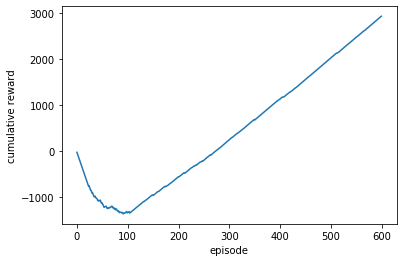

In [10]:

#Plotted is the cumulative reward obtained by the Agent for the 50 trials it does after every episode. We can see that
# Until episode 100, the Agent is not performing well at all, but after that, it increases at a steady pace
plt.plot(h)
plt.xlabel("episode")
plt.ylabel("cumulative reward")
plt.show()

# Results

To see for myself how well my Agent could solve the maze, I visualised the path taken by the Agent for a few different positions

In [128]:
def play_visualize(start_pos):
    a = game.play(model, start_cell = start_pos)
    outcome = a[0].name
    moves = np.reshape(a[1], (np.shape(a[1])[0],2))
    prev = start_pos
    fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(5,5))
    fig.canvas.set_window_title("Best move")
    ax1.set_xticks(np.arange(0.5, 8, step=1))
    ax1.set_xticklabels([])
    ax1.set_yticks(np.arange(0.5, 8, step=1))
    ax1.set_yticklabels([])
    ax1.grid(True)
    ax1.plot(*(7,7), "gs", markersize=30)
    ax1.text(*(7,7), "Exit", ha="center", va="center", color="white")
    ax1.text(*start_pos, "Start")
    
    for cell in game.empty:
        q = model.q(cell) if model is not None else [0, 0, 0, 0]
        a = np.nonzero(q == np.max(q))[0]
        
    
    
    for i in moves[1:]:
        
        ax1.plot(*zip(*[(prev), i]), "bo-")  

        prev = i
    ax1.get_figure().canvas.draw()
    ax1.get_figure().canvas.flush_events()
        
    ax1.get_figure().canvas.draw()
    #ax1.set_ylim(ax2.get_ylim()[::-1]) 
    ax1.imshow(maze, cmap="binary")

## Scenario 1

First. lets see how the model performs from the upper left of the maze to the exit.

Here, we see that our Agent was succesfuly able to reach the end of the Maze without bumping into any obstacles. It took the shortest path possible through the maze, with only 20 moves. 

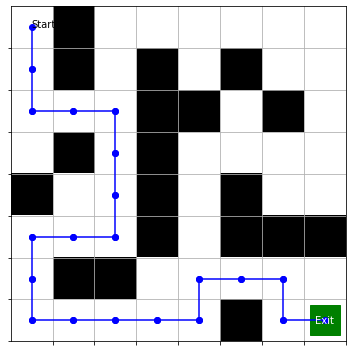

In [129]:
play_visualize((0,0))

Now, lets see how it performs from some other starting point

## Scenario 2

What if we start from the upper right corner?

Again it is able to trace the most optimal path to the exit!



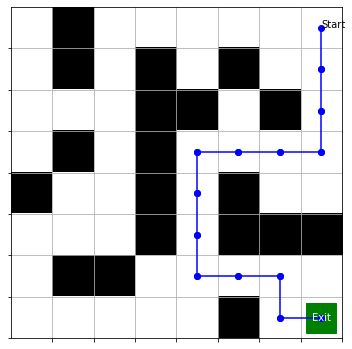

In [130]:
play_visualize((7,0))

Lets try 1 last time, from  (4,1)

## Scenario 3

Lets try starting from a point that was covered in neither of the 2 passed routes

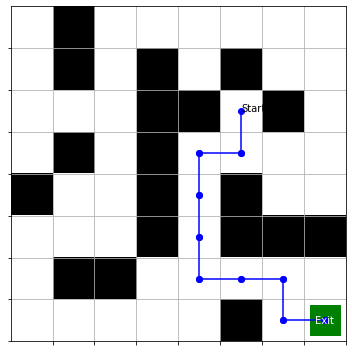

In [133]:
play_visualize((5,2))

# Conclusion

My RL Agent was able to completely optimally find its way out of a maze, from any starting point. The same algorythm could be applied to a much larger maze. I will shortly be posting the solution for a larger maze on GitHub.com/Artash-N

